In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load input data

In [2]:
train = pd.read_csv("../data/train.csv")
store = pd.read_csv("../data/store.csv")

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Merge train and store

In [3]:
merged_train_store = pd.merge(store, train, on='Store', how='left')

In [4]:
100 * merged_train_store.isnull().sum() / len(merged_train_store)

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.264361
CompetitionOpenSinceMonth    31.760481
CompetitionOpenSinceYear     31.760481
Promo2                        0.000000
Promo2SinceWeek              49.095918
Promo2SinceYear              49.095918
PromoInterval                49.095918
Date                          0.000000
DayOfWeek                     2.981052
Sales                         2.982345
Customers                     2.993825
Open                          3.014036
Promo                         3.020665
StateHoliday                  3.007407
SchoolHoliday                 3.037643
dtype: float64

# Drop the customer column

In [5]:
merged_train_store = merged_train_store.drop('Customers', axis=1)

# Drop missing values

In [6]:
missing_col_5per = (100 * merged_train_store.isnull().sum() / len(merged_train_store)) < 5
cols_to_drop = merged_train_store.columns[missing_col_5per]
cols_to_drop

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2',
       'Date', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [7]:
cleaned_df = merged_train_store.dropna(axis=0, subset=cols_to_drop)
100 * cleaned_df.isnull().sum() / len(cleaned_df)

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth    31.578650
CompetitionOpenSinceYear     31.578650
Promo2                        0.000000
Promo2SinceWeek              49.073484
Promo2SinceYear              49.073484
PromoInterval                49.073484
Date                          0.000000
DayOfWeek                     0.000000
Sales                         0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
dtype: float64

In [8]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513483 entries, 0 to 618472
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      513483 non-null  int64  
 1   StoreType                  513483 non-null  object 
 2   Assortment                 513483 non-null  object 
 3   CompetitionDistance        513483 non-null  float64
 4   CompetitionOpenSinceMonth  351332 non-null  float64
 5   CompetitionOpenSinceYear   351332 non-null  float64
 6   Promo2                     513483 non-null  int64  
 7   Promo2SinceWeek            261499 non-null  float64
 8   Promo2SinceYear            261499 non-null  float64
 9   PromoInterval              261499 non-null  object 
 10  Date                       513483 non-null  object 
 11  DayOfWeek                  513483 non-null  float64
 12  Sales                      513483 non-null  float64
 13  Open                       51

In [9]:
cleaned_df.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     152913
Feb,May,Aug,Nov      59555
Mar,Jun,Sept,Dec     49031
Name: PromoInterval, dtype: int64

In [10]:
cleaned_df.CompetitionOpenSinceYear

0         2008.0
2         2008.0
3         2008.0
5         2008.0
6         2008.0
           ...  
618464       NaN
618465       NaN
618470       NaN
618471       NaN
618472       NaN
Name: CompetitionOpenSinceYear, Length: 513483, dtype: float64

In [11]:
missing_promo = cleaned_df.Promo2SinceWeek.isnull()
cleaned_df[['Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']][missing_promo]['Promo2'].unique()

array([0])

# Encode the missing columns

In [12]:
mean_encode_cols = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']
zero_encode_cols = ['Promo2SinceWeek', 'Promo2SinceYear']
string_encode_cols = ['PromoInterval']

In [13]:
mean_encode = np.floor(cleaned_df[mean_encode_cols].mean())
string_encode = 'unavailable'

In [14]:
cleaned_df[mean_encode_cols] = cleaned_df[mean_encode_cols].fillna(mean_encode, axis=0)
cleaned_df[zero_encode_cols] = cleaned_df[zero_encode_cols].fillna(0, axis=0)
cleaned_df[string_encode_cols] = cleaned_df[string_encode_cols].fillna(string_encode, axis=0)

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
cleaned_df.CompetitionOpenSinceMonth.value_counts()

7.0     192762
9.0      57825
4.0      43545
11.0     42457
3.0      32335
12.0     29587
10.0     28165
6.0      23132
5.0      20208
2.0      19005
8.0      18069
1.0       6393
Name: CompetitionOpenSinceMonth, dtype: int64

In [16]:
cleaned_df.CompetitionOpenSinceYear.value_counts()

2008.0    187011
2013.0     38279
2012.0     37793
2014.0     32267
2005.0     28601
2010.0     25587
2009.0     25067
2011.0     25005
2007.0     22191
2006.0     21693
2015.0     17477
2002.0     12485
2004.0     10043
2003.0      8708
2001.0      7429
2000.0      4625
1999.0      3685
1990.0      2298
1994.0       941
1995.0       919
1998.0       474
1961.0       460
1900.0       445
Name: CompetitionOpenSinceYear, dtype: int64

In [17]:
cleaned_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Date                         0
DayOfWeek                    0
Sales                        0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
dtype: int64

# Drop rows with no sales

In [18]:
zero_sales_mask = cleaned_df.Sales == 0
np.sum(zero_sales_mask)

87794

In [19]:
len(cleaned_df) - np.sum(zero_sales_mask)

425689

In [20]:
zero_sales_mask = cleaned_df.Sales == 0
nonzero_sales = cleaned_df.loc[~zero_sales_mask]
nonzero_sales.shape

(425689, 17)

### Convert categorical to float

In [21]:
nonzero_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425689 entries, 2 to 618472
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      425689 non-null  int64  
 1   StoreType                  425689 non-null  object 
 2   Assortment                 425689 non-null  object 
 3   CompetitionDistance        425689 non-null  float64
 4   CompetitionOpenSinceMonth  425689 non-null  float64
 5   CompetitionOpenSinceYear   425689 non-null  float64
 6   Promo2                     425689 non-null  int64  
 7   Promo2SinceWeek            425689 non-null  float64
 8   Promo2SinceYear            425689 non-null  float64
 9   PromoInterval              425689 non-null  object 
 10  Date                       425689 non-null  object 
 11  DayOfWeek                  425689 non-null  float64
 12  Sales                      425689 non-null  float64
 13  Open                       42

In [22]:
nonzero_sales.StateHoliday.value_counts()

0      380057
0.0     45164
a         358
b          78
c          32
Name: StateHoliday, dtype: int64

In [23]:
nonzero_sales.Date = pd.to_datetime(nonzero_sales.Date)

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [24]:
categorical_col_mask = nonzero_sales.dtypes == 'object'
categorical_cols = nonzero_sales.columns[categorical_col_mask]
nonzero_sales = pd.get_dummies(nonzero_sales, columns=categorical_cols, drop_first=True)

In [25]:
nonzero_sales.dtypes

Store                                      int64
CompetitionDistance                      float64
CompetitionOpenSinceMonth                float64
CompetitionOpenSinceYear                 float64
Promo2                                     int64
Promo2SinceWeek                          float64
Promo2SinceYear                          float64
Date                              datetime64[ns]
DayOfWeek                                float64
Sales                                    float64
Open                                     float64
Promo                                    float64
SchoolHoliday                            float64
StoreType_b                                uint8
StoreType_c                                uint8
StoreType_d                                uint8
Assortment_b                               uint8
Assortment_c                               uint8
PromoInterval_Jan,Apr,Jul,Oct              uint8
PromoInterval_Mar,Jun,Sept,Dec             uint8
PromoInterval_unavai

In [26]:
#nonzero_sales = nonzero_sales.drop('Date', axis=1)

### Encode the Date column

In [27]:
nonzero_sales['Year'] = nonzero_sales['Date'].dt.year
nonzero_sales['Month'] = nonzero_sales['Date'].dt.month
nonzero_sales['DayOfMonth'] = nonzero_sales['Date'].dt.day

In [28]:
nonzero_sales = nonzero_sales.drop('Date', axis=1)

# Train and test data preparation

In [29]:
X = nonzero_sales.drop('Sales', axis=1)
y = nonzero_sales[['Sales']]

In [30]:
X.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Open,Promo,...,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_unavailable,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,Year,Month,DayOfMonth
2,1,1270.0,9.0,2008.0,0,0.0,0.0,4.0,1.0,0.0,...,0,0,1,1,0,0,0,2013,1,3
3,1,1270.0,9.0,2008.0,0,0.0,0.0,5.0,1.0,0.0,...,0,0,1,1,0,0,0,2013,1,4
6,1,1270.0,9.0,2008.0,0,0.0,0.0,1.0,1.0,1.0,...,0,0,1,1,0,0,0,2013,1,7
7,1,1270.0,9.0,2008.0,0,0.0,0.0,2.0,1.0,1.0,...,0,0,1,1,0,0,0,2013,1,8
8,1,1270.0,9.0,2008.0,0,0.0,0.0,3.0,1.0,1.0,...,0,0,1,1,0,0,0,2013,1,9


In [31]:
assert len(X) == len(y)

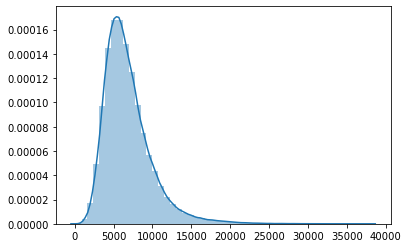

In [32]:
sns.distplot(y)

### train test split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [34]:
assert len(X_train) + len(X_test) == len(X)

In [35]:
assert len(X_train) == len(y_train)

In [36]:
X_train.shape

(340551, 26)

### Baseline Random Forest

In [37]:
rf = RandomForestRegressor(n_estimators=100, 
                           min_samples_leaf=3, 
                           max_depth=5, 
                           random_state=42)

In [38]:
rf.fit(X_train, y_train)

<ipython-input-38-168a6fc83696>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [43]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [40]:
y_pred = rf.predict(X_test)

In [46]:
rf_base_metric = metric(y_pred, y_test.values)

print("Metric for baseline prediction = {}".format(rf_base_metric))

Metric for baseline prediction = 55.35548149537605


#### Feature importance

In [51]:
def plot_feature_importances(model, dataset, title):
    """
    This function calculates the feature importance and plot a horizontal bar chart.
    ...
    Attributes
    ----------
    model : sklearn.tree._classes.DecisionTreeRegressor
         the regression decision tree model
    dataset : pandas.core.frame.DataFrame
         the training dataset
    title: str
         the title for the plot
    plt:  str
         just type plt when you call the function
    """
    n_features = dataset.shape[1]
    
    sorted_idx = model.feature_importances_.argsort()
    plt.figure(figsize=(8, 8))
    plt.barh(range(n_features), model.feature_importances_[sorted_idx], align='center')
    plt.yticks(np.arange(n_features), dataset.columns[sorted_idx])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.title(title)

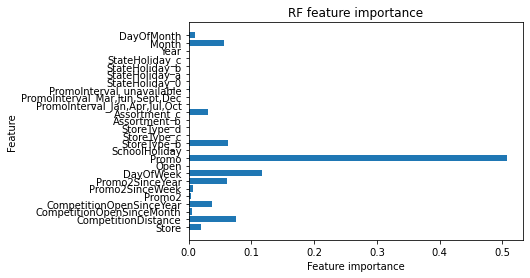

In [49]:
plot_feature_importances(rf, X_train, "RF feature importance")

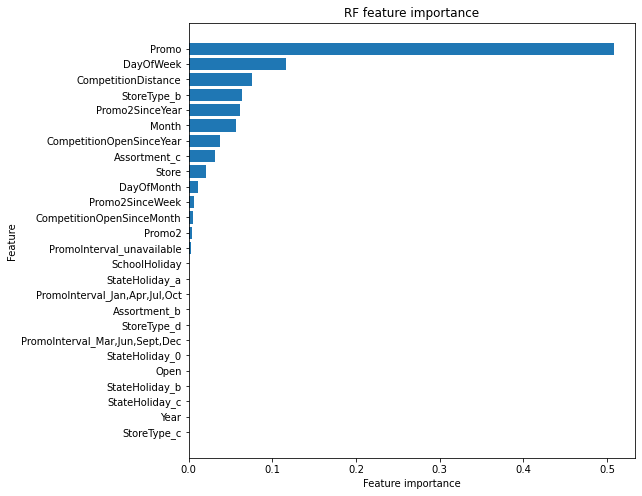

In [52]:
plot_feature_importances(rf, X_train, "RF feature importance")